# Libraries & Settings

In [136]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import qgrid
from datetime import datetime as dtt

from pa_lib.file import data_files, load_bin, store_bin, load_csv, write_xlsx, load_xlsx
from pa_lib.data import (
    calc_col_partitioned,
    clean_up_categoricals,
    unfactorize,
    flatten,
    replace_col,
    cond_col,
    desc_col,
    unfactorize,
    as_dtype,
    flatten_multi_index_cols,
)
from pa_lib.util import obj_size, cap_words, normalize_rows, clear_row_max
from pa_lib.log import time_log, info
from pa_lib.vis import dive

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 200)


def qshow(df, fit_width=False):
    return qgrid.show_grid(
        df, grid_options={"forceFitColumns": fit_width, "fullWidthRows": False}
    )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [3]:
bd_raw = load_bin("bd_data.feather").rename(
    mapper=lambda name: cap_words(name, sep="_"), axis="columns"
)
bd = bd_raw.loc[(bd_raw.Netto > 0)].pipe(clean_up_categoricals)

2019-08-15 09:18:41 [INFO] Reading from file C:\Users\kpf\data\bd_data.feather
C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
2019-08-15 09:18:42 [INFO] Finished loading binary file in 0.65s (0.47s CPU)


In [4]:
desc_col(bd)

,DTYPE,NULLS,UNIQUE
Endkunde_NR,category,0/662686,31777
Endkunde,category,0/662686,29880
EK_Abc,category,1161/661525,8
EK_Boni,category,76/662610,3
EK_Plz,category,155/662531,2958
EK_Ort,category,155/662531,3006
EK_Land,category,155/662531,46
EK_HB_Apg_Kurzz,category,27195/635491,83
EK_Aktiv,category,0/662686,2
Agentur,category,316433/346253,3908


# Prepare Endkunden Information

In [187]:
def last_notna(s):
    try:
        return s.loc[s.notna()].iat[-1]
    except IndexError:
        return np.NaN


def collect(s, sep=","):
    return sep.join(map(str, s[s.notna()].unique()))


# this takes around 110 seconds
with time_log("preparing EK_INFO"):
    ek_info = (
        bd.sort_values(["Endkunde_NR", "Kampagne_Erfassungsdatum"])
        .astype({"Endkunde_NR": "int64", "Kamp_Erfass_Jahr": "int16"})
        .groupby("Endkunde_NR")
        .agg(
            {
                "Endkunde": last_notna,
                "EK_Aktiv": last_notna,
                "EK_Land": last_notna,
                "EK_Plz": last_notna,
                "EK_Ort": last_notna,
                "Agentur": last_notna,
                "Endkunde_Branchengruppe": last_notna,
                "Endkunde_Branchengruppe_ID": last_notna,
                "Auftrag_Branchengruppe_ID": [collect, "nunique"],
                "Kamp_Erfass_Jahr": ["min", "max"],
            }
        )
    )

ek_info.set_axis(
    labels="Endkunde EK_Aktiv EK_Land EK_Plz EK_Ort Agentur EK_BG EK_BG_ID Auftrag_BG_ID Auftrag_BG_Anz Kamp_Erfass_Jahr_min Kamp_Erfass_Jahr_max".split(),
    axis="columns",
    inplace=True,
)

2019-08-15 15:43:10 [INFO] Finished preparing EK_INFO in 111.23s (112.39s CPU)


In [188]:
ek_info.head(10)

,Endkunde,EK_Aktiv,EK_Land,EK_Plz,EK_Ort,Agentur,EK_BG,EK_BG_ID,Auftrag_BG_ID,Auftrag_BG_Anz,Kamp_Erfass_Jahr_min,Kamp_Erfass_Jahr_max
Endkunde_NR,,,,,,,,,,,,
100034,Maurer + Salzmann AG,1,SCHWEIZ,8408,Winterthur,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,"720,405,400,295",4,2009,2018
100039,Bank BSU Genossenschaft,1,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Finanzwirtschaft,470,"470,720",2,2009,2019
100061,Mundwiler Juwelen AG,1,SCHWEIZ,8400,Winterthur,NaN,WG - Persönlicher Bedarf,555,555,1,2009,2009
100064,Senn Communication,1,SCHWEIZ,8610,Uster,NaN,WG - Dienstleistung,720,"901,960",2,2009,2017
100066,"walder, werber werbeagentur ag",1,SCHWEIZ,8610,Uster,"walder, werber werbeagentur ag",WG - Dienstleistung,720,"780,720",2,2013,2019
100083,Goodyear Dunlop Tires Suisse SA,1,SCHWEIZ,8604,Volketswil,a.ha GmbH,WG - Fahrzeugzubehör,390,390,1,2011,2019
100092,Navyboot AG,1,SCHWEIZ,8001,Zürich,Kinetic Worldwide Switzerland AG,WG - Bekleidung / Wäsche,195,195,1,2009,2015
100095,Zomag AG,1,SCHWEIZ,8620,Wetzikon ZH,ACE 2 ACE outdoor media ag,WG - Dienstleistung,720,720,1,2009,2019
100097,Biomed AG,1,SCHWEIZ,8600,Dübendorf,mediaschneider ag,WG - Pharma Produkte,366,"366,800,720",3,2009,2018


### How many customers started or ended in which year?

In [189]:
pd.crosstab(
    index=ek_info.Kamp_Erfass_Jahr_min,
    columns=ek_info.Kamp_Erfass_Jahr_max,
    margins=True,
)

Kamp_Erfass_Jahr_max,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Kamp_Erfass_Jahr_min,,,,,,,,,,,,,
2007,0,3,0,0,1,0,1,0,0,0,2,2,9
2008,265,145,105,85,84,93,98,117,115,98,325,588,2118
2009,0,1614,510,346,295,305,258,300,260,279,693,1158,6018
2010,0,0,1242,275,186,145,127,131,100,128,260,337,2931
2011,0,0,0,1309,244,173,136,167,126,131,232,343,2861
2012,0,0,0,0,1121,228,150,146,164,114,194,252,2369
2013,0,0,0,0,0,1128,261,162,146,141,226,265,2329
2014,0,0,0,0,0,0,1181,265,183,142,279,308,2358
2015,0,0,0,0,0,0,0,1369,279,203,288,299,2438


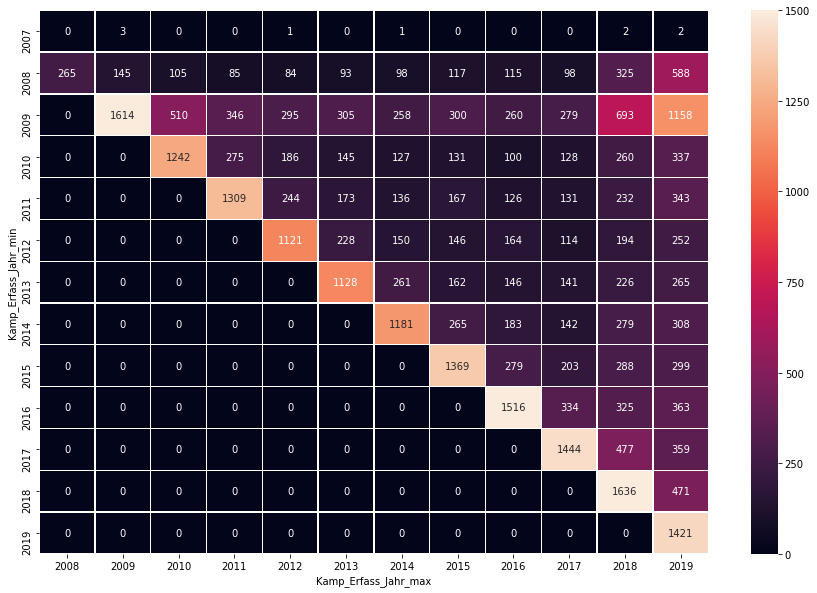

In [190]:
import seaborn as sns
import matplotlib.pyplot as plt

plot_data = pd.crosstab(
    index=ek_info.Kamp_Erfass_Jahr_min, columns=ek_info.Kamp_Erfass_Jahr_max
)

plt.figure(figsize=(15, 10))
sns.heatmap(data=plot_data, linewidths=0.3, vmax=1500, annot=True, fmt="d")

### Store and reload result

In [191]:
store_bin(ek_info, "bd_cluster_ek_info.feather")

2019-08-15 15:46:00 [INFO] Writing to file C:\Users\kpf\data\bd_cluster_ek_info.feather
2019-08-15 15:46:00 [INFO] Written 4.1 MB
2019-08-15 15:46:00 [INFO] Finished storing binary file in 0.04s (0.05s CPU)


In [192]:
ek_info = load_bin('bd_cluster_ek_info.feather')

2019-08-15 15:46:02 [INFO] Reading from file C:\Users\kpf\data\bd_cluster_ek_info.feather
C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
2019-08-15 15:46:02 [INFO] Finished loading binary file in 0.02s (0.02s CPU)


# Distribution of Auftragsart

In [193]:
display(
    pd.crosstab(
        index=[bd.Auftragsart, bd.Vertrag], columns=bd.Kamp_Erfass_Jahr, margins=True
    )
)
display("Netto-Umsatz")
display(
    bd.pivot_table(
        index=["Auftragsart", "Vertrag"],
        columns="Kamp_Erfass_Jahr",
        values="Netto",
        aggfunc="sum",
        fill_value=0,
        margins=True,
    )
)

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,88,2003,1629,1745,2223,2703,1488,26,14,16,21,13,11969
Eigenwerbung APG,Nein,0,0,79,0,1,13,0,1,123,56,82,56,0,411
Goodwill,Nein,0,0,6,7,6,9,9,5,6,4,12,13,8,85
Karitativ,Nein,0,104,227,238,224,351,265,304,442,564,547,598,406,4270
Kommerziell,Nein,0,6078,34516,38627,39748,37761,36611,40953,43260,48152,50064,49006,33807,458583
Logistik für Dritte,Nein,0,0,0,0,4,13,6,31,387,353,371,378,190,1733
Politisch,Nein,0,354,1934,1773,4847,3068,2492,2733,5842,3536,3106,3275,3825,36785
Promotion,Nein,0,60,2283,1879,1728,1823,3048,1212,2102,2736,2965,3854,680,24370
Sponsoring,Nein,0,40,139,124,179,181,171,172,218,208,245,358,76,2111


'Netto-Umsatz'

,Kamp_Erfass_Jahr,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,All
Auftragsart,Vertrag,,,,,,,,,,,,,,
Aushangauftrag Partner,Nein,0,30444,849600,791206,739514,1026394,1000669,439344,110412,92214,117954,150966,72198,5420915
Eigenwerbung APG,Nein,0,0,3897655,0,4670,1048532,0,360,133390,126540,1222454,72427,0,6506028
Goodwill,Nein,0,0,6543,7939,4953,18668,2994,4762,4191,1732,17772,16741,5925,92220
Karitativ,Nein,0,724644,1960077,1628917,1866012,2668615,2253943,2318474,2578634,3459117,2775404,3962032,2632140,28828009
Kommerziell,Nein,0,33806952,148051046,162393013,168628594,175031787,158519973,182560236,193519765,204222602,197001081,191949492,145654263,1961338804
Logistik für Dritte,Nein,0,0,0,0,4600,184578,31589,132394,479850,420927,418245,522661,239121,2433965
Politisch,Nein,0,2040430,6938949,6463858,18562173,11082670,9945225,10458567,16977360,11414298,6379246,8489070,10458705,119210551
Promotion,Nein,0,1083041,5375644,4376195,3393104,3505266,5451654,3185928,3787542,4991362,4881049,9304271,1960374,51295430
Sponsoring,Nein,0,348746,1097029,1087749,2340803,2588788,3282531,3450304,3740079,3906123,3671259,3432667,438138,29384216


### Auftragsart vs. customers

In [155]:
%%time

ek_auftragsart = pd.crosstab(columns=bd.Auftragsart, index=bd.Endkunde_NR)
ek_auftragsart.mask(ek_auftragsart == 0, inplace=True)

ek_auftragsart.head(10)

Wall time: 5.35 s


Auftragsart,Aushangauftrag Partner,Eigenwerbung APG,Goodwill,Karitativ,Kommerziell,Logistik für Dritte,Politisch,Promotion,Sponsoring,Traffic Auftrag,Vertragsvorschrift (OC),langfristiger Vertrag
Endkunde_NR,,,,,,,,,,,,
100034,NaN,NaN,NaN,NaN,119.0,NaN,NaN,13.0,NaN,18.0,NaN,NaN
100039,NaN,NaN,NaN,NaN,50.0,NaN,NaN,1.0,NaN,16.0,NaN,NaN
100061,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100064,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,9.0,NaN,NaN
100066,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100083,NaN,NaN,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100092,NaN,NaN,NaN,NaN,27.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
100095,NaN,NaN,NaN,NaN,106.0,NaN,NaN,16.0,NaN,NaN,NaN,NaN
100097,NaN,NaN,NaN,NaN,144.0,NaN,NaN,NaN,NaN,17.0,NaN,NaN


How many **different** Auftragsart per customer?

In [156]:
ek_auftragsart.count(axis='columns').value_counts()

1    23712
2     5866
3     1771
4      381
5       34
6       10
7        2
8        1
dtype: int64

How many **most frequent** Auftragsart per customer? 

In [157]:
(ek_auftragsart.subtract(ek_auftragsart.max(axis='columns'), axis='index') == 0).sum(axis='columns').value_counts()

1    31010
2      745
3       22
dtype: int64

Where is the a **clear favourite** Auftragsart for a customer?

In [231]:
%%time
ek_auftragsart_scoring = clear_row_max(ek_auftragsart)

Wall time: 21.4 s


In [232]:
ek_auftragsart_scoring = ek_auftragsart_scoring.loc[ek_auftragsart_scoring.notnull()]

ek_auftragsart_scoring.value_counts()

Kommerziell                15254
Traffic Auftrag             8019
Politisch                   3149
Promotion                   1422
langfristiger Vertrag       1083
Karitativ                     85
Vertragsvorschrift (OC)       76
Sponsoring                    12
Logistik für Dritte            6
Eigenwerbung APG               4
Goodwill                       2
Aushangauftrag Partner         1
dtype: int64

# Branchen

In [225]:
ek_branchen = ek_info.loc[:,['Endkunde_NR', 'EK_BG_ID', 'Auftrag_BG_ID']]

In [226]:
def unique_list(lst):
    return list(set(lst))


ek_branchen["Auftrag_BG_list"] = ek_branchen.Auftrag_BG_ID.str.split(",")
ek_branchen["BG_list"] = ek_branchen.apply(
    lambda x: unique_list([x.EK_BG_ID] + x.Auftrag_BG_list), axis="columns"
)
ek_branchen.drop(
    ["EK_BG_ID", "Auftrag_BG_ID", "Auftrag_BG_list"], axis="columns", inplace=True
)

ek_branchen.head()

,Endkunde_NR,BG_list
0,100034,"[405, 720, 295, 400]"
1,100039,"[720, 470]"
2,100061,[555]
3,100064,"[901, 720, 960]"
4,100066,"[780, 720]"


# Restrict bookings to interesting customers (current & long-term)

### List of current long-time customers

* "Current" means that their last booking was not more than two years back. 
* "Long-time" means that they had at least two years of bookings.

In [183]:
limit_year = pd.Timestamp.today().year - 2

ek_nr_current = ek_info.loc[
    (ek_info.Kamp_Erfass_Jahr_max >= limit_year)
    & (ek_info.Kamp_Erfass_Jahr_min < limit_year - 2),
    "Endkunde_NR"
]

KeyError: 'Endkunde_NR'

In [34]:
bd_current = bd.loc[bd.Endkunde_NR.isin(ek_nr_current)].pipe(clean_up_categoricals)

print(f'Keeping {bd_current.shape[0]} of {bd.shape[0]} records')

Keeping 461569 of 662686 records


# Aggregate bookings per customer, year, and KW_2 / KW_4 period

Both by Reservation and Aushang.

In [ ]:
def sum_calc(df, col_year, col_week):
    return (
        df.loc[:, ["Endkunde_NR", col_year, col_week, "Netto"]]
        .pipe(unfactorize)
        .groupby(["Endkunde_NR", col_year, col_week], observed=True, as_index=False)
        .agg({"Netto": ["sum"]})
        .set_axis(
            f"Endkunde_NR {col_year} {col_week} Netto_Sum".split(),
            axis="columns",
            inplace=False,
        )
    )


def aggregate_bookings(df, period):
    info(f"Period: {period}")
    info("Calculate Reservation...")
    df_res = sum_calc(df, "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}")
    info("Calculate Aushang...")
    df_aus = sum_calc(df, "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}")

    info("Merge Results...")
    df_aggr = df_res.merge(
        right=df_aus,
        left_on=["Endkunde_NR", "Kamp_Erfass_Jahr", f"Kamp_Erfass_{period}"],
        right_on=["Endkunde_NR", "Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"],
        how="outer",
        suffixes=("_Res", "_Aus"),
    ).rename(
        {"Kamp_Erfass_Jahr": "Jahr", f"Kamp_Erfass_{period}": period}, axis="columns"
    )

    df_aggr = (
        df_aggr.fillna(
            {
                "Jahr": df_aggr.Kamp_Beginn_Jahr,
                period: df_aggr[f"Kamp_Beginn_{period}"],
                "Netto_Sum_Res": 0,
                "Netto_Sum_Aus": 0,
            }
        )
        .drop(["Kamp_Beginn_Jahr", f"Kamp_Beginn_{period}"], axis="columns")
        .astype({"Jahr": "int16"})
        .astype({period: "int8"})
        .sort_values(["Jahr", "Endkunde_NR", period])
        .reset_index(drop=True)
    )

    return df_aggr

In [ ]:
bd_aggr_2w = aggregate_bookings(bd_current, 'KW_2')
bd_aggr_4w = aggregate_bookings(bd_current, 'KW_4')

In [ ]:
bd_aggr_2w.head(10)

### Calculate sum curve per customer * year, over periods

In [ ]:
def make_year_grp_sumcurve(df, year_col, grp_col, data_col, prefix=''):
    # build new columns with sum/cumsum per year/grp
    df = (df
          .pipe(calc_col_partitioned, f'{prefix}sumJahr', fun='sum',    on=data_col, part_by=[year_col, grp_col])
          .pipe(calc_col_partitioned, f'{prefix}cumJahr', fun='cumsum', on=data_col, part_by=[year_col, grp_col]))

    # divide data_col by sum to get scaled amounts, show in %
    df = (df.eval(f'{prefix}prcJahr = ({data_col} / {prefix}sumJahr) * 100 + 0.5')
            .fillna({f'{prefix}prcJahr': 0})
            .astype({f'{prefix}prcJahr': 'int'}))

    # divide cumsum by sum to get sum curve [0, 1], show in %
    df = (df.eval(f'{prefix}crvJahr = ({prefix}cumJahr / {prefix}sumJahr) * 100 + 0.5')
            .fillna({f'{prefix}crvJahr': 0})
            .astype({f'{prefix}crvJahr': 'int'}))
    return df

In [ ]:
bd_aggr_2w = (
    bd_aggr_2w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_2"])
    .reset_index(drop=True)
)

bd_aggr_4w = (
    bd_aggr_4w.pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Res",
        prefix="Res_",
    )
    .pipe(
        make_year_grp_sumcurve,
        year_col="Jahr",
        grp_col="Endkunde_NR",
        data_col="Netto_Sum_Aus",
        prefix="Aus_",
    )
    .sort_values(["Endkunde_NR", "Jahr", "KW_4"])
    .reset_index(drop=True)
)

In [ ]:
bd_aggr_2w.head(10)

In [ ]:
bd_aggr_4w.head(10)

### Store and reload results

In [ ]:
store_bin(bd_aggr_2w, 'bd_cluster_aggr_2w.feather')
store_bin(bd_aggr_4w, 'bd_cluster_aggr_4w.feather')

In [2]:
bd_aggr_2w = load_bin('bd_cluster_aggr_2w.feather')
bd_aggr_4w = load_bin('bd_cluster_aggr_4w.feather')

2019-08-14 10:30:52 [INFO] Reading from file C:\Users\kpf\data\bd_cluster_aggr_2w.feather
C:\ProgramData\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels
2019-08-14 10:30:52 [INFO] Finished loading binary file in 0.13s (0.03s CPU)
2019-08-14 10:30:52 [INFO] Reading from file C:\Users\kpf\data\bd_cluster_aggr_4w.feather
2019-08-14 10:30:52 [INFO] Finished loading binary file in 0.0s (0.0s CPU)


# Clustering Customers by Reservation

### Drop incomplete years

We have data for the last 10 years, the current year is incomplete

In [3]:
valid_years = list(range(pd.Timestamp.today().year - 10, pd.Timestamp.today().year))
valid_years

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]

### Pivot prc values by period

In [22]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

# drop years with no reservations
bd_res_prc_2w_data = bd_res_prc_2w_data.loc[bd_res_prc_2w_data.sum(axis="columns") > 0]

bd_res_prc_2w_data.head(12)

KW_2              1   3   5   7   9   11  13  15  17  19  21  23  25  27  29  \
Endkunde_NR Jahr                                                               
100034      2009   0   0   0  33   2   0   0   0   6   0   0   0   0   0   0   
            2010   0   0   0   0  31   0   0   0   0   0   0   0   0   0  12   
            2011   0   0   0   0  40   0   0   0   0   0   0   0   0   0   0   
            2012   0   0   0   0  29   0   0   0   0   0   0   0   0   0   8   
            2013   0   0  52   2   0   0   0   0   0   0   0   0   0   0   0   
            2014   0  40   2   0   0   0   0   0   0   0   0   0   0   0   0   
            2015   0   0  44   0   0   0   0   0   0   0   0   0   0   0   0   
            2016   0  57   0   0   0   0   0   0   0   0   0   0   0   0   0   
            2017   0   0  28   0   0   0   0   0   0   0   0   0   0   0   0   
            2018   0   0  26   0   0   0   0   0   0   0   0   0   0   0   0   
100039      2009  23   0   0   0   0   0  55   0   0   0   0   0   0   0   0   
            2010   0   0   0   0   0   0   0   0  55   0   0   0   0   0   0   

KW_2              31  33  35  37  39  41  43  45  47  49  51  
Endkunde_NR Jahr                                              
100034      2009   0   0   0   0  14   0   6  40   0   0   0  
            2010   0   0   0   0   0   0  57   0   0   0   0  
            2011  14   0   0   0   4   2  41   0   0   0   0  
            2012   9   0   0   0   0   0  51   2   0   0   0  
            2013  14   0   0   0   0   0  32   0   0   0   0  
            2014   0   0   0   0   0   0  58   0   0   0   0  
            2015   0   0   0   0   0   0  51   5   0   0   0  
            2016   0   0   0   0   0  39   4   0   0   0   0  
            2017   0   0   0   0   0  26  47   0   0   0   0  
            2018   0   0   0   0   0   0  74   0   0   0   0  
100039      2009   0   0   0   0   0   0   0   0   0   0  23  
            2010   0   0   0   0   0   0   0   0   0   0  45

### Prepare data: Aggregate over years by customer

In [23]:
ek_2w_prc_mean = (
    bd_res_prc_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

ek_2w_prc_mean_stack = (
    ek_2w_prc_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "prc_mean"], axis="columns", inplace=False)
)

display(ek_2w_prc_mean.head(10))

KW_2,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,
100034,0.000000,9.7,15.2,3.500000,10.200000,0.000000,0.000000,0.0,0.6,0.0,0.0,0.0,0.000000,0.0,2.0,3.7,0.000000,0.0,0.0,1.8,6.7,42.1,4.7,0.0,0.0,0.0
100039,2.300000,5.3,0.0,0.000000,4.200000,8.800000,11.200000,8.5,5.5,0.0,0.0,3.1,0.000000,0.0,0.0,8.9,0.000000,16.8,0.0,0.0,0.0,0.0,12.7,2.6,2.2,8.0
100064,0.000000,0.0,0.0,0.000000,11.111111,0.000000,83.111111,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,5.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100066,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,50.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0
100083,12.333333,0.0,0.0,33.333333,0.000000,0.666667,0.000000,0.0,0.0,0.0,0.0,0.0,33.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
100095,0.000000,0.0,1.8,22.300000,9.600000,2.200000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,32.9,31.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100097,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,6.400000,0.0,7.2,0.0,3.200000,11.6,0.0,0.0,26.0,7.6,3.0,14.8,20.0,0.0
100098,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
100104,0.000000,0.0,0.0,0.000000,2.700000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,10.0,80.0,3.700000,3.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Pivot crv values by period

In [24]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

### Aggregate over years by customer

In [25]:
ek_2w_crv_mean = (
    bd_res_crv_2w_data.reset_index()
    .drop("Jahr", axis="columns")
    .groupby("Endkunde_NR")
    .agg("mean")
)

ek_2w_crv_mean_stack = (
    ek_2w_crv_mean.stack()
    .reset_index()
    .set_axis(["Endkunde_NR", "KW_2", "crv_mean"], axis="columns", inplace=False)
)

display(bd_res_crv_2w_data.head(10))
display(ek_2w_crv_mean.head(10))

KW_2               1     3     5     7     9     11    13    15    17    19  \
Endkunde_NR Jahr                                                              
100034      2009  0.0   0.0   0.0  33.0  35.0  35.0  35.0  35.0  41.0  41.0   
            2010  0.0   0.0   0.0   0.0  31.0  31.0  31.0  31.0  31.0  31.0   
            2011  0.0   0.0   0.0   0.0  40.0  40.0  40.0  40.0  40.0  40.0   
            2012  0.0   0.0   0.0   0.0  29.0  29.0  29.0  29.0  29.0  29.0   
            2013  0.0   0.0  52.0  54.0  54.0  54.0  54.0  54.0  54.0  54.0   
            2014  0.0  40.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0   
            2015  0.0   0.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0   
            2016  0.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0   
            2017  0.0   0.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
            2018  0.0   0.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   

KW_2                21    23    25    27    29    31    33    35    37    39  \
Endkunde_NR Jahr                                                               
100034      2009  41.0  41.0  41.0  41.0  41.0  41.0  41.0  41.0  41.0  54.0   
            2010  31.0  31.0  31.0  31.0  43.0  43.0  43.0  43.0  43.0  43.0   
            2011  40.0  40.0  40.0  40.0  40.0  54.0  54.0  54.0  54.0  57.0   
            2012  29.0  29.0  29.0  29.0  37.0  46.0  46.0  46.0  46.0  46.0   
            2013  54.0  54.0  54.0  54.0  54.0  68.0  68.0  68.0  68.0  68.0   
            2014  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0   
            2015  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0   
            2016  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0   
            2017  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
            2018  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   

KW_2                41     43     45     47     49     51  
Endkunde_NR Jahr                                           
100034      2009  54.0   60.0  100.0  100.0  100.0  100.0  
            2010  43.0  100.0  100.0  100.0  100.0  100.0  
            2011  59.0  100.0  100.0  100.0  100.0  100.0  
            2012  46.0   98.0  100.0  100.0  100.0  100.0  
            2013  68.0  100.0  100.0  100.0  100.0  100.0  
            2014  42.0  100.0  100.0  100.0  100.0  100.0  
            2015  44.0   95.0  100.0  100.0  100.0  100.0  
            2016  96.0  100.0  100.0  100.0  100.0  100.0  
            2017  53.0  100.0  100.0  100.0  100.0  100.0  
            2018  26.0  100.0  100.0  100.0  100.0  100.0

KW_2,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41,43,45,47,49,51
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,
100034,0.000000,9.700000,24.900000,28.400000,38.600000,38.600000,38.600000,38.600000,39.200000,39.200000,39.200000,39.200000,39.200000,39.200000,41.200000,44.900000,44.9,44.9,44.9,46.5,53.1,95.3,100.0,100.0,100.0,100.0
100039,2.300000,7.600000,7.600000,7.600000,11.800000,20.600000,31.700000,40.200000,45.700000,45.700000,45.700000,48.800000,48.800000,48.800000,48.800000,57.700000,57.7,74.4,74.4,74.4,74.4,74.4,87.2,89.8,92.0,100.0
100064,0.000000,0.000000,0.000000,0.000000,11.111111,11.111111,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,94.222222,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
100066,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,50.0,50.0,50.0,50.0,50.0,100.0,100.0,100.0
100083,12.333333,12.333333,12.333333,45.666667,45.666667,46.666667,46.666667,46.666667,46.666667,46.666667,46.666667,46.666667,80.000000,80.000000,80.000000,80.000000,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,80.0,100.0
100095,0.000000,0.000000,1.800000,24.100000,33.700000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,35.800000,68.800000,100.000000,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
100097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.400000,6.400000,13.600000,13.600000,16.8,28.4,28.4,28.4,54.4,62.2,65.2,80.0,100.0,100.0
100098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
100104,0.000000,0.000000,0.000000,0.000000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,2.700000,12.700000,92.700000,96.3,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


### Plot customer booking patterns (global)

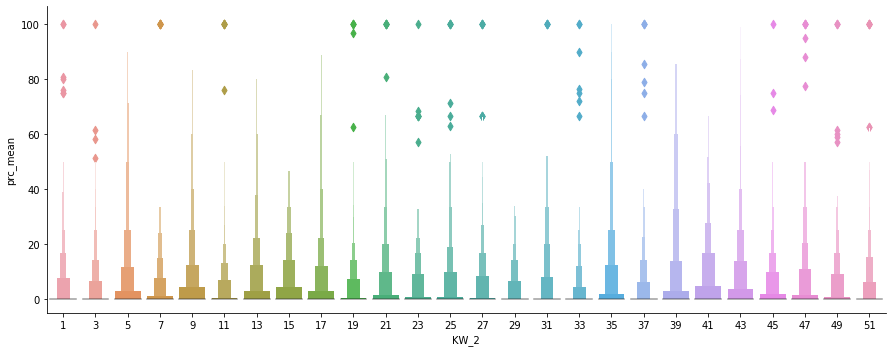

In [27]:
import seaborn as sns
%matplotlib inline

sns.catplot(
    data=ek_2w_prc_mean_stack, x="KW_2", y="prc_mean", aspect=2.5, kind="boxen"
)

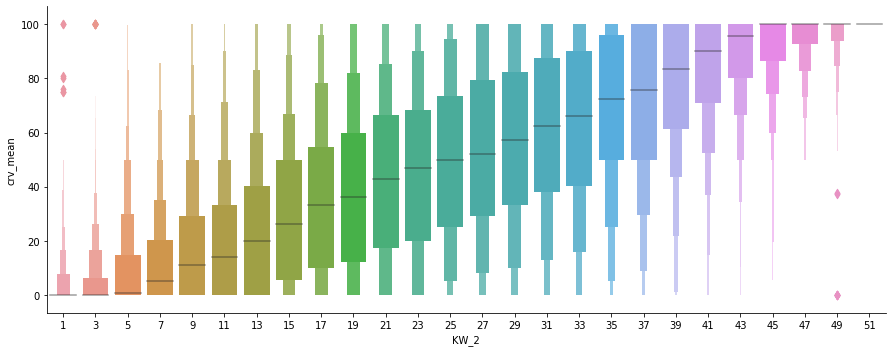

In [28]:
sns.catplot(
    data=ek_2w_crv_mean_stack, x="KW_2", y="crv_mean", aspect=2.5, kind="boxen"
)

### Cluster booking patterns (percentage of yearly sum)

Prepare data

In [31]:
X = ek_2w_prc_mean.to_numpy()

X_columns = ek_2w_prc_mean.columns

#### Normal KMeans

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

for n_clusters in range(5, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

For n_clusters = 5: Silhouette_score = 0.12530054488899683,  CH score = 498.5237420787123
For n_clusters = 6: Silhouette_score = 0.12997437775113793,  CH score = 479.28344462099017
For n_clusters = 7: Silhouette_score = 0.1456269403405358,  CH score = 451.8357618395498
For n_clusters = 8: Silhouette_score = 0.16627626082582536,  CH score = 509.20206893412484
For n_clusters = 9: Silhouette_score = 0.1741131680129115,  CH score = 524.712899116957
For n_clusters = 10: Silhouette_score = 0.17788602447599403,  CH score = 523.233989338445
For n_clusters = 11: Silhouette_score = 0.2052234197850331,  CH score = 538.6730403692712
For n_clusters = 12: Silhouette_score = 0.2061044574509544,  CH score = 561.1340172305742
For n_clusters = 13: Silhouette_score = 0.18958604793052075,  CH score = 560.9819543492888
For n_clusters = 14: Silhouette_score = 0.204136511103338,  CH score = 568.788912219702
For n_clusters = 15: Silhouette_score = 0.21264926567692718,  CH score = 572.2425839235023
For n_clust

In [33]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

prc_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

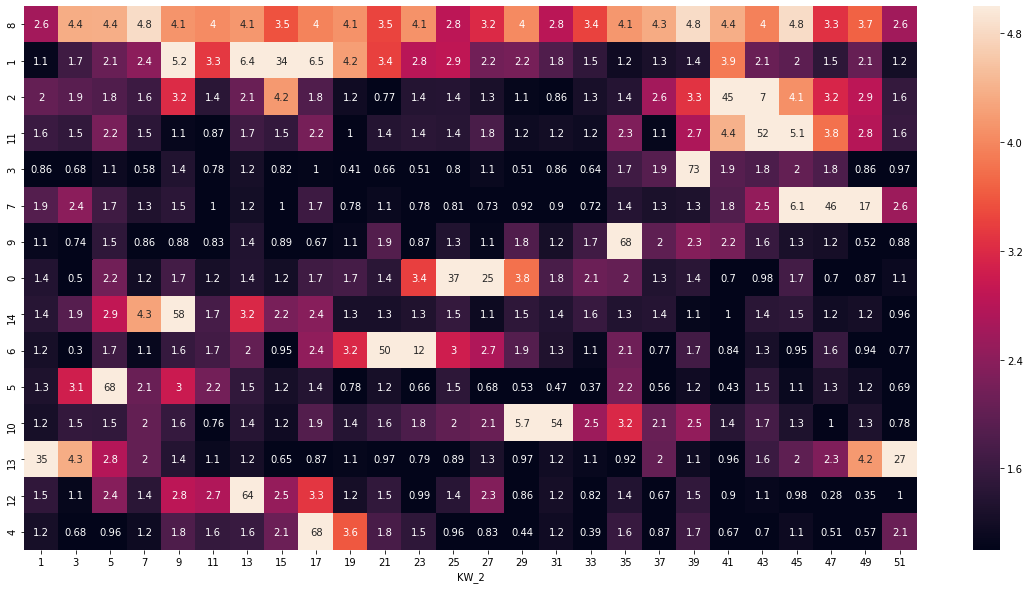

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True, vmin=1, vmax=5)

Cluster sizes

In [40]:
pd.Series(prc_nkmeans_labels).value_counts()

8     2504
1      484
2      445
11     314
3      292
7      275
9      275
0      273
14     266
6      248
5      241
10     237
13     234
12     205
4      204
dtype: int64

Plot scaled bookings by cluster

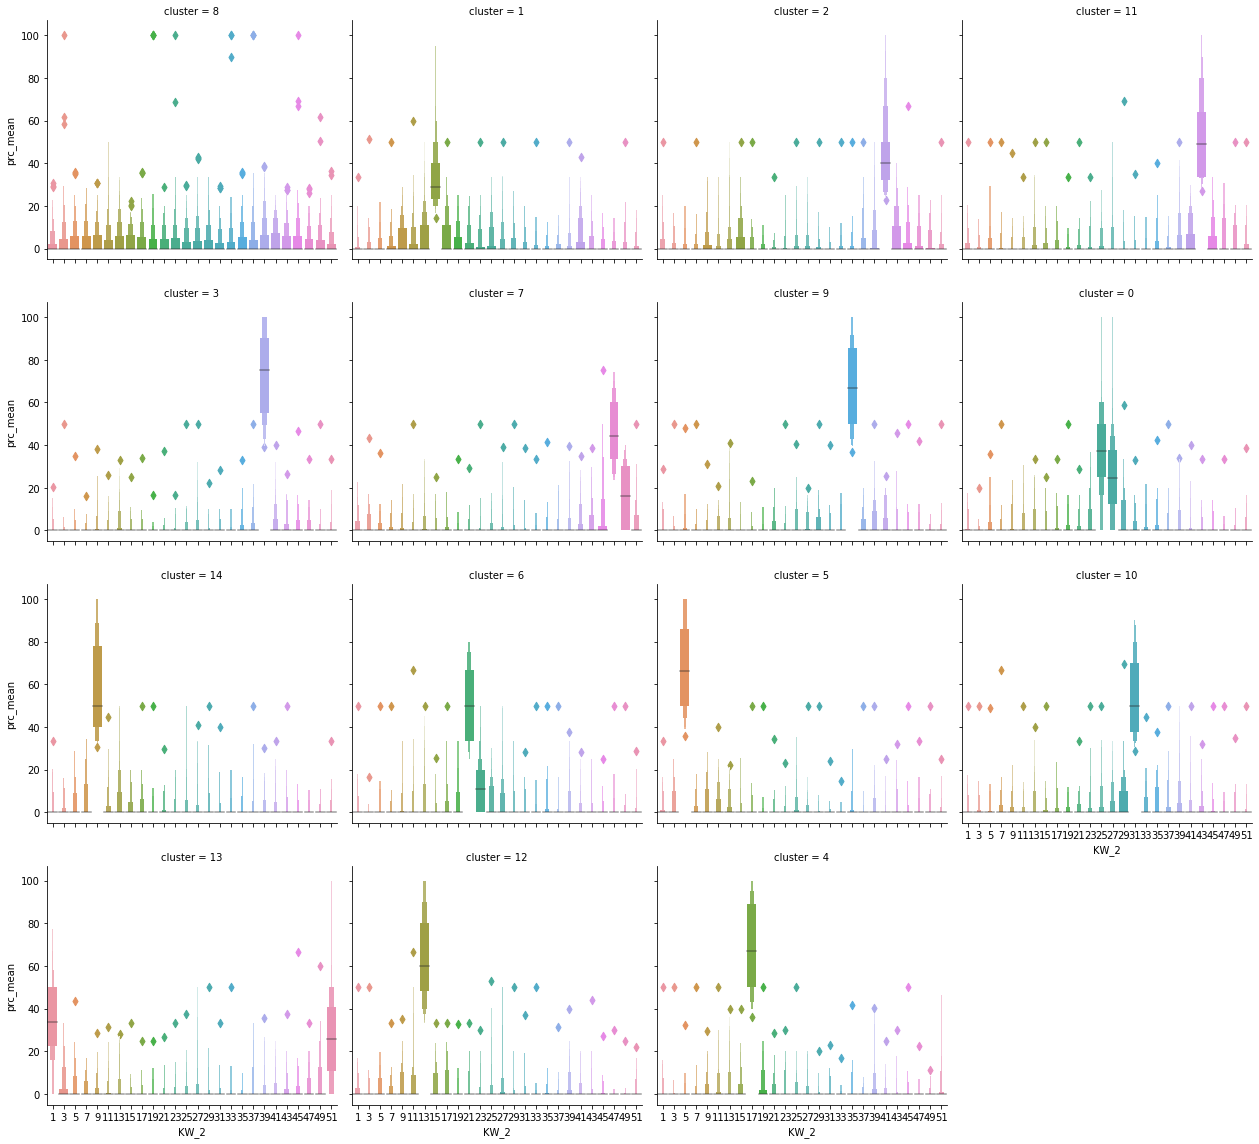

In [41]:
plot_data = ek_2w_prc_mean_stack.merge(
    pd.Series(data=prc_nkmeans_labels, index=ek_2w_prc_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc_mean",
    aspect=1.1,
    kind="boxen",
    col="cluster",
    col_wrap=4,
    col_order=pd.Series(prc_nkmeans_labels).value_counts().index,  # order by cluster size
    height=4,
)

### Cluster booking patterns (cumulative percentage of yearly sum)

Prepare data

In [42]:
X = ek_2w_crv_mean.to_numpy()

X_columns = ek_2w_crv_mean.columns

#### Normal KMeans

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

for n_clusters in range(3, 21):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

For n_clusters = 3: Silhouette_score = 0.28291870538096603,  CH score = 4227.78528044592
For n_clusters = 4: Silhouette_score = 0.24235912282513786,  CH score = 3621.736195375264
For n_clusters = 5: Silhouette_score = 0.24685502645083676,  CH score = 3371.33186075902
For n_clusters = 6: Silhouette_score = 0.24140178953013938,  CH score = 3144.8882536659958
For n_clusters = 7: Silhouette_score = 0.2366282098683372,  CH score = 3000.010354858167
For n_clusters = 8: Silhouette_score = 0.23853224098012496,  CH score = 2863.405403307344
For n_clusters = 9: Silhouette_score = 0.23173450349612526,  CH score = 2732.1563350742917
For n_clusters = 10: Silhouette_score = 0.2254966200743738,  CH score = 2606.9397631589813
For n_clusters = 11: Silhouette_score = 0.2259657943008852,  CH score = 2517.0153598241623
For n_clusters = 12: Silhouette_score = 0.22187811499775736,  CH score = 2426.9707422705187
For n_clusters = 13: Silhouette_score = 0.22341536900517336,  CH score = 2355.3372669069904
For n

In [44]:
nkmeans = KMeans(n_clusters=15, random_state=0, verbose=1, n_jobs=-1)

crv_nkmeans_labels = nkmeans.fit_predict(X)

Show cluster centroids sorted by cluster size (number of rows)

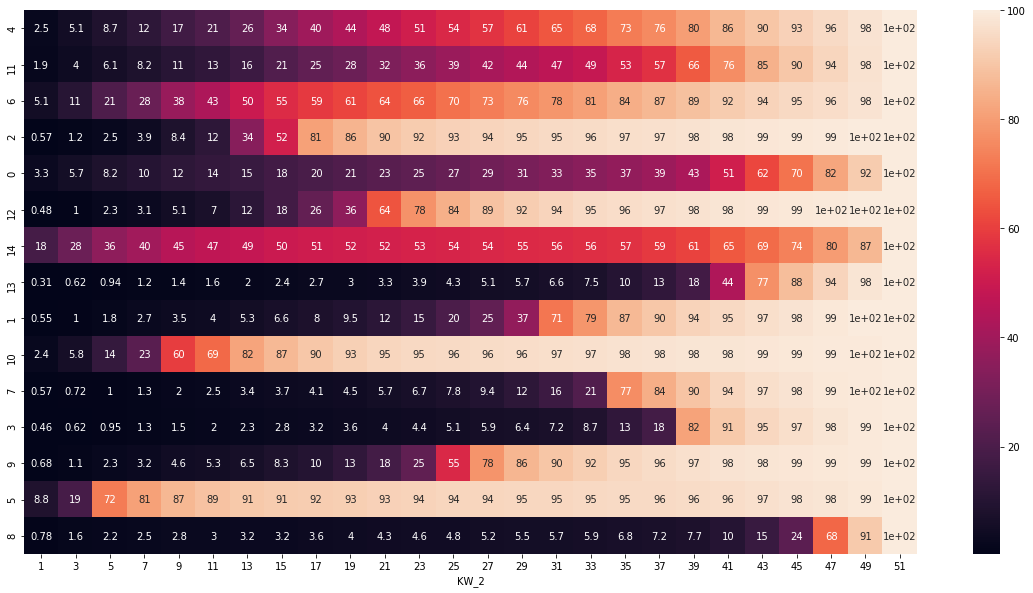

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(crv_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(20, 10))
sns.heatmap(nkmeans_clusters, annot=True, fmt='d')

Cluster sizes

In [46]:
pd.Series(crv_nkmeans_labels).value_counts()

4     996
11    847
6     640
2     490
0     448
12    381
14    367
13    350
1     321
10    317
7     305
3     303
9     279
5     257
8     196
dtype: int64

Plot scaled bookings by cluster

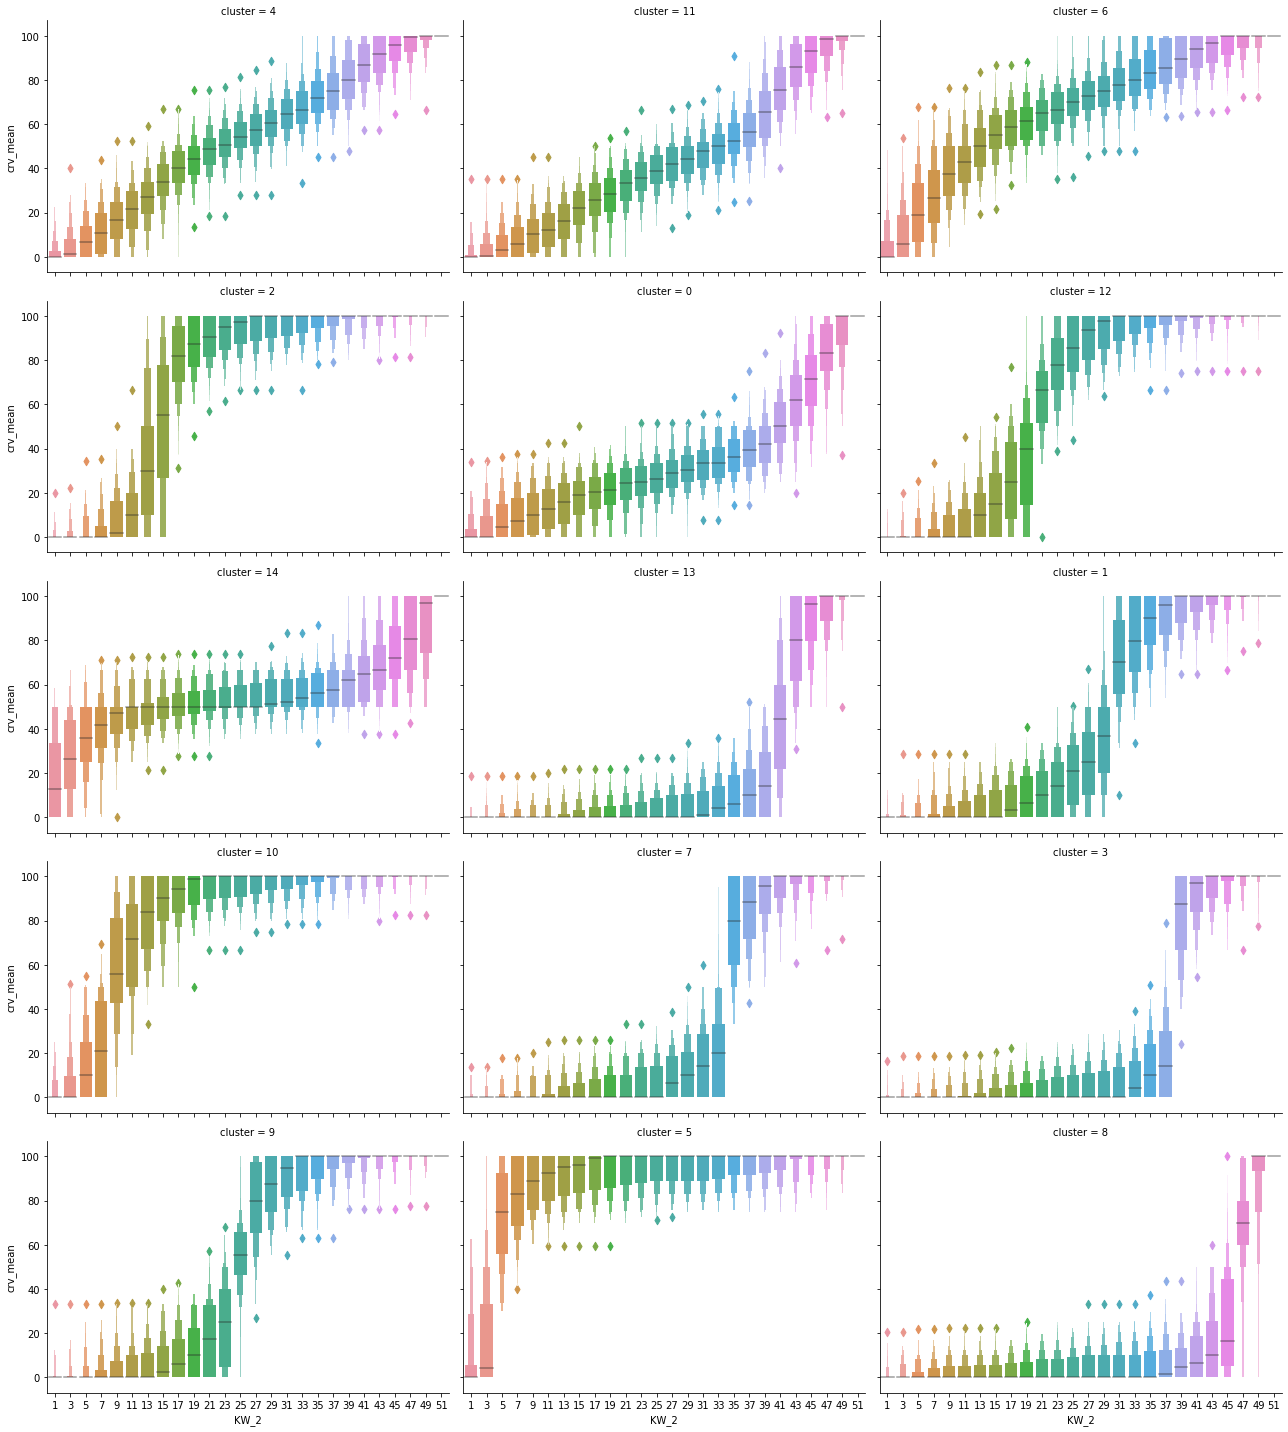

In [47]:
plot_data = ek_2w_crv_mean_stack.merge(
    pd.Series(data=crv_nkmeans_labels, index=ek_2w_crv_mean.index, name="cluster"),
    on="Endkunde_NR",
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="crv_mean",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    col_order=pd.Series(crv_nkmeans_labels).value_counts().index, # order by cluster size
    height=4,
)

# PCA on Customers

### Prepare Data

In [48]:
X = ek_2w_crv_mean.to_numpy()
X_columns = ek_2w_crv_mean.columns
X_index = ek_2w_crv_mean.index

y = crv_nkmeans_labels

### Calculate standard PCA with 4 components

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4, random_state=0)
X_pca = pca.fit_transform(X)

In [51]:
pca.explained_variance_ratio_

array([0.65050785, 0.15133325, 0.06180178, 0.03862892])

In [52]:
pca.components_

array([[ 0.01127127,  0.02477633,  0.07810039,  0.09696679,  0.14226558,
         0.15779023,  0.19603524,  0.22046479,  0.25138302,  0.26174776,
         0.27596678,  0.28170709,  0.28572854,  0.28652392,  0.28449141,
         0.2751315 ,  0.27074285,  0.23880831,  0.22787381,  0.17386836,
         0.13401237,  0.08917667,  0.06785762,  0.03021502,  0.00875142,
        -0.        ],
       [ 0.06055912,  0.10102964,  0.20810386,  0.23829701,  0.28754233,
         0.29686689,  0.29149218,  0.27013885,  0.21464123,  0.18519422,
         0.10981537,  0.06408031, -0.00923509, -0.06685738, -0.10771022,
        -0.17709016, -0.1985332 , -0.26628427, -0.27769873, -0.28368602,
        -0.25131258, -0.20189156, -0.17023748, -0.09918063, -0.05075159,
        -0.        ],
       [-0.03710302, -0.07933173, -0.22704838, -0.25755705, -0.28247382,
        -0.27282139, -0.19265173, -0.09831932,  0.06185614,  0.11311776,
         0.19613509,  0.23131584,  0.23693322,  0.22949336,  0.19963194,
       

### Plot K-means clusters against principal components

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


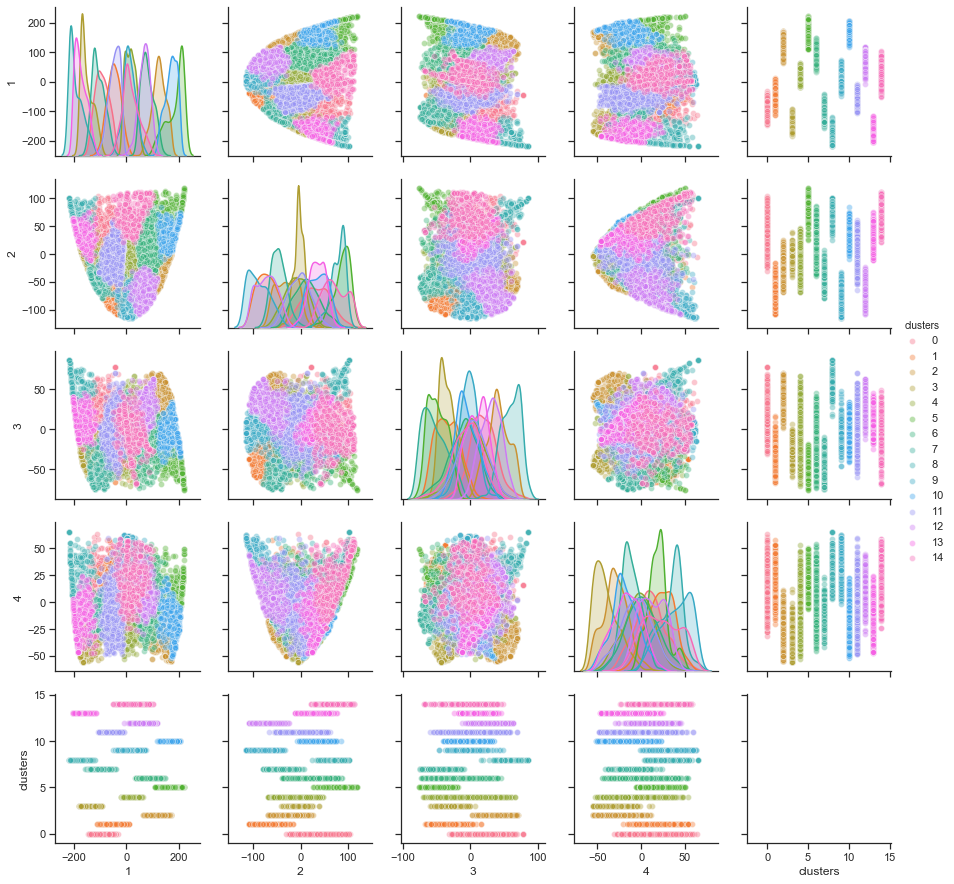

In [53]:
plot_data = pd.DataFrame(X_pca, index=X_index, columns=range(1, pca.n_components + 1))
plot_data["clusters"] = y
sns.set(style="ticks")
sns.pairplot(data=plot_data, hue="clusters", plot_kws={"alpha": 0.4})

# Clustering Customer Booking Years

### Prepare data: Pivot prc values by period

In [54]:
bd_res_prc_2w_data = bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))].pivot_table(
    index=["Endkunde_NR", "Jahr"],
    columns="KW_2",
    values="Res_prcJahr",
    aggfunc="sum",
    fill_value=0,
)

# drop years with no reservations
bd_res_prc_2w_data = bd_res_prc_2w_data.loc[bd_res_prc_2w_data.sum(axis="columns") > 0]

bd_res_prc_2w_data_stack = bd_res_prc_2w_data.stack()

bd_res_prc_2w_data.head(12)

KW_2              1   3   5   7   9   11  13  15  17  19  21  23  25  27  29  \
Endkunde_NR Jahr                                                               
100034      2009   0   0   0  33   2   0   0   0   6   0   0   0   0   0   0   
            2010   0   0   0   0  31   0   0   0   0   0   0   0   0   0  12   
            2011   0   0   0   0  40   0   0   0   0   0   0   0   0   0   0   
            2012   0   0   0   0  29   0   0   0   0   0   0   0   0   0   8   
            2013   0   0  52   2   0   0   0   0   0   0   0   0   0   0   0   
            2014   0  40   2   0   0   0   0   0   0   0   0   0   0   0   0   
            2015   0   0  44   0   0   0   0   0   0   0   0   0   0   0   0   
            2016   0  57   0   0   0   0   0   0   0   0   0   0   0   0   0   
            2017   0   0  28   0   0   0   0   0   0   0   0   0   0   0   0   
            2018   0   0  26   0   0   0   0   0   0   0   0   0   0   0   0   
100039      2009  23   0   0   0   0   0  55   0   0   0   0   0   0   0   0   
            2010   0   0   0   0   0   0   0   0  55   0   0   0   0   0   0   

KW_2              31  33  35  37  39  41  43  45  47  49  51  
Endkunde_NR Jahr                                              
100034      2009   0   0   0   0  14   0   6  40   0   0   0  
            2010   0   0   0   0   0   0  57   0   0   0   0  
            2011  14   0   0   0   4   2  41   0   0   0   0  
            2012   9   0   0   0   0   0  51   2   0   0   0  
            2013  14   0   0   0   0   0  32   0   0   0   0  
            2014   0   0   0   0   0   0  58   0   0   0   0  
            2015   0   0   0   0   0   0  51   5   0   0   0  
            2016   0   0   0   0   0  39   4   0   0   0   0  
            2017   0   0   0   0   0  26  47   0   0   0   0  
            2018   0   0   0   0   0   0  74   0   0   0   0  
100039      2009   0   0   0   0   0   0   0   0   0   0  23  
            2010   0   0   0   0   0   0   0   0   0   0  45

In [55]:
X = bd_res_prc_2w_data.to_numpy()

X_columns = bd_res_prc_2w_data.columns
X_index = bd_res_prc_2w_data.index

#### Normal KMeans

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

for n_clusters in range(25, 31):
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

For n_clusters = 25: Silhouette_score = 0.5700902138193812,  CH score = 8834.689899135514
For n_clusters = 26: Silhouette_score = 0.5786340112610775,  CH score = 9772.72923686792
For n_clusters = 27: Silhouette_score = 0.5926437677387898,  CH score = 10770.471697935656
For n_clusters = 28: Silhouette_score = 0.5927905604888558,  CH score = 10694.675280804597
For n_clusters = 29: Silhouette_score = 0.5928712758381314,  CH score = 10690.198559345285
For n_clusters = 30: Silhouette_score = 0.5950370402191338,  CH score = 10663.672570872048


In [57]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_prc_nkmeans_labels = nkmeans.fit_predict(X)

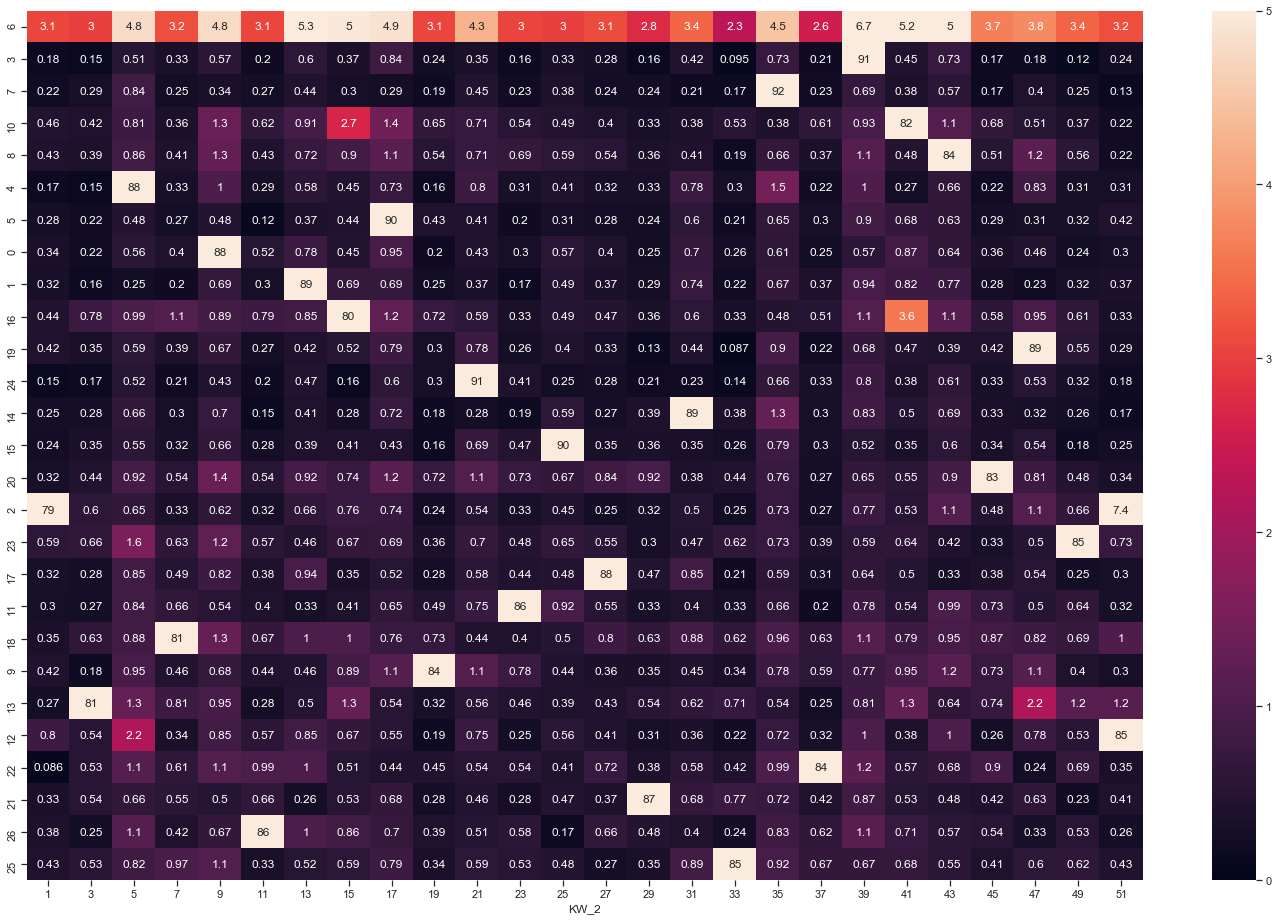

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns).loc[
    pd.Series(yr_prc_nkmeans_labels).value_counts().index
]

plt.figure(figsize=(25, 16))
sns.heatmap(yr_nkmeans_clusters, annot=True, vmin=0, vmax=5)

In [63]:
pd.Series(yr_prc_nkmeans_labels).value_counts()

6     4954
3     2656
7     2300
10    2222
8     2156
4     2136
5     2086
0     1999
1     1963
16    1911
19    1592
24    1572
14    1539
15    1349
20    1238
2     1236
23    1150
17    1140
11    1043
18     994
9      931
13     900
12     887
22     859
21     815
26     814
25     661
dtype: int64

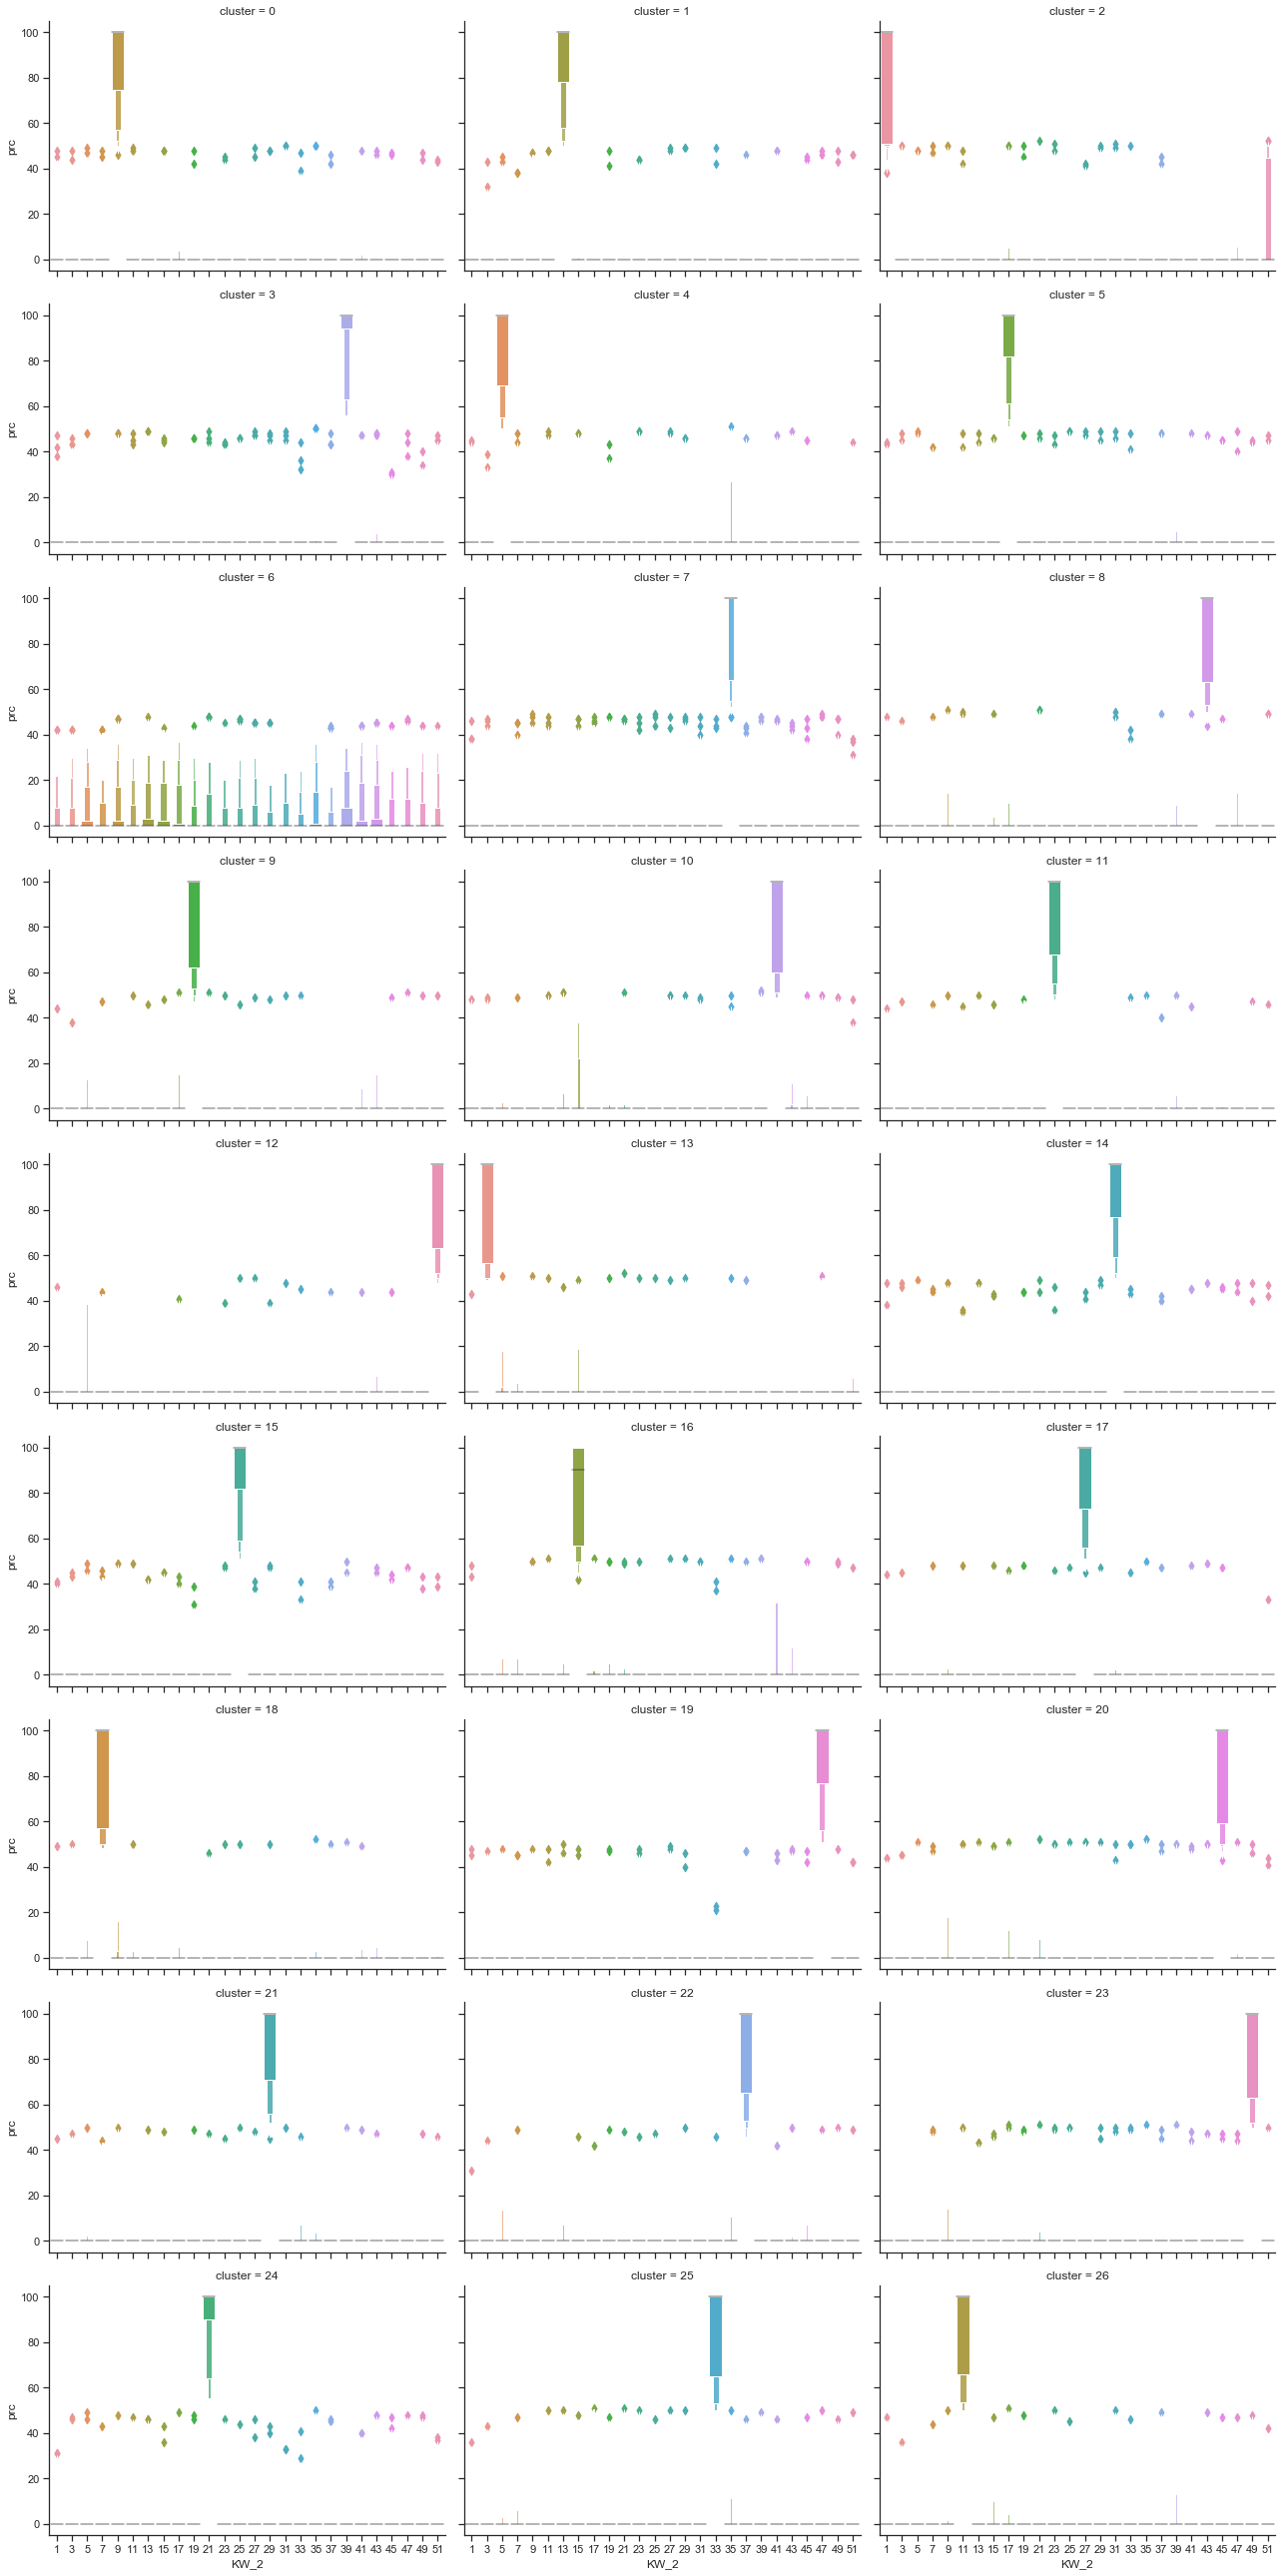

In [64]:
plot_data = (
    pd.DataFrame.from_dict({"prc": bd_res_prc_2w_data_stack})
    .reset_index()
    .merge(
        pd.Series(
            data=yr_prc_nkmeans_labels, index=bd_res_prc_2w_data.index, name="cluster"
        ),
        on=["Endkunde_NR", "Jahr"],
    )
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [66]:
ek_prc_cls = pd.crosstab(
    index=bd_res_prc_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_prc_nkmeans_labels, name="cluster"),
)

ek_prc_cls_yr_cnt_ = ek_prc_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_prc_cls = ek_prc_cls.assign(
    n_yr=ek_prc_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_prc_cls_yr_cnt_.where(ek_prc_cls > 0).count(axis="columns"),
    cls=ek_prc_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_prc_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_prc_cls["n_main_cls"] = ek_prc_cls["main_cls"].apply(len)

ek_prc_cls

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,n_yr,n_cls,cls,main_cls,n_main_cls
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100034,0,0,0,0,1,0,2,0,6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,10,4,"[4, 6, 8, 13]",[8],1
100039,0,2,0,0,0,1,1,2,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,10,8,"[1, 5, 6, 7, 14, 16, 20, 26]","[1, 7]",2
100064,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,9,3,"[0, 1, 25]",[1],1
100066,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,2,2,"[19, 22]","[19, 22]",2
100083,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,3,3,"[12, 15, 18]","[12, 15, 18]",3
100095,1,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,1,0,0,4,0,0,0,0,0,10,5,"[0, 6, 14, 18, 21]",[21],1
100097,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,5,4,"[6, 10, 19, 23]",[6],1
100098,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1,[3],[3],1
100104,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,0,10,3,"[6, 14, 21]",[14],1


### Customers that can be related to 1 or 2 clusters

In [67]:
max_main_cls = 2

ek_clust_scoring = ek_prc_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

### Prepare data: Pivot crv values by period

In [68]:
bd_res_crv_2w_data = (
    bd_aggr_2w.loc[(bd_aggr_2w.Jahr.isin(valid_years))]
    .pivot_table(
        index=["Endkunde_NR", "Jahr"],
        columns="KW_2",
        values="Res_crvJahr",
        aggfunc="sum",
    )
    .fillna(method="ffill", axis=1)
    .fillna(0)
)

# drop years with no reservations
bd_res_crv_2w_data = bd_res_crv_2w_data.loc[bd_res_crv_2w_data.sum(axis="columns") > 0]

bd_res_crv_2w_data_stack = bd_res_crv_2w_data.stack()

bd_res_crv_2w_data.head(12)

KW_2                1     3     5     7     9     11    13    15    17    19  \
Endkunde_NR Jahr                                                               
100034      2009   0.0   0.0   0.0  33.0  35.0  35.0  35.0  35.0  41.0  41.0   
            2010   0.0   0.0   0.0   0.0  31.0  31.0  31.0  31.0  31.0  31.0   
            2011   0.0   0.0   0.0   0.0  40.0  40.0  40.0  40.0  40.0  40.0   
            2012   0.0   0.0   0.0   0.0  29.0  29.0  29.0  29.0  29.0  29.0   
            2013   0.0   0.0  52.0  54.0  54.0  54.0  54.0  54.0  54.0  54.0   
            2014   0.0  40.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0   
            2015   0.0   0.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0   
            2016   0.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0   
            2017   0.0   0.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
            2018   0.0   0.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   
100039      2009  23.0  23.0  23.0  23.0  23.0  23.0  77.0  77.0  77.0  77.0   
            2010   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  55.0  55.0   

KW_2                21    23    25    27    29    31    33    35    37    39  \
Endkunde_NR Jahr                                                               
100034      2009  41.0  41.0  41.0  41.0  41.0  41.0  41.0  41.0  41.0  54.0   
            2010  31.0  31.0  31.0  31.0  43.0  43.0  43.0  43.0  43.0  43.0   
            2011  40.0  40.0  40.0  40.0  40.0  54.0  54.0  54.0  54.0  57.0   
            2012  29.0  29.0  29.0  29.0  37.0  46.0  46.0  46.0  46.0  46.0   
            2013  54.0  54.0  54.0  54.0  54.0  68.0  68.0  68.0  68.0  68.0   
            2014  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0  42.0   
            2015  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0  44.0   
            2016  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0  57.0   
            2017  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0  28.0   
            2018  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0  26.0   
100039      2009  77.0  77.0  77.0  77.0  77.0  77.0  77.0  77.0  77.0  77.0   
            2010  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0  55.0   

KW_2                41     43     45     47     49     51  
Endkunde_NR Jahr                                           
100034      2009  54.0   60.0  100.0  100.0  100.0  100.0  
            2010  43.0  100.0  100.0  100.0  100.0  100.0  
            2011  59.0  100.0  100.0  100.0  100.0  100.0  
            2012  46.0   98.0  100.0  100.0  100.0  100.0  
            2013  68.0  100.0  100.0  100.0  100.0  100.0  
            2014  42.0  100.0  100.0  100.0  100.0  100.0  
            2015  44.0   95.0  100.0  100.0  100.0  100.0  
            2016  96.0  100.0  100.0  100.0  100.0  100.0  
            2017  53.0  100.0  100.0  100.0  100.0  100.0  
            2018  26.0  100.0  100.0  100.0  100.0  100.0  
100039      2009  77.0   77.0   77.0   77.0   77.0  100.0  
            2010  55.0   55.0   55.0   55.0   55.0  100.0

### Prepare for clustering

In [69]:
X = bd_res_crv_2w_data.to_numpy()

X_columns = bd_res_crv_2w_data.columns
X_index = bd_res_crv_2w_data.index

#### Normal KMeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score

for n_clusters in [15, 25, 35, 40]:
    kmeans_ = KMeans(
        n_clusters=n_clusters,
        random_state=0,
        n_jobs=-1
    )
    cluster_labels_ = kmeans_.fit_predict(X)
    ch_score = calinski_harabasz_score(X, cluster_labels_)
    sil_score = silhouette_score(X, cluster_labels_)
    print(
        f"For n_clusters = {n_clusters}: Silhouette_score = {sil_score},  CH score = {ch_score}"
    )

```
For n_clusters = 5: Silhouette_score = 0.3049945347740261,  CH score = 29630.89896114061
For n_clusters = 10: Silhouette_score = 0.366230862992324,  CH score = 26973.062027368196
For n_clusters = 15: Silhouette_score = 0.40334656127747526,  CH score = 25417.006073311764
For n_clusters = 20: Silhouette_score = 0.44202548618962784,  CH score = 24818.708849953175
For n_clusters = 25: Silhouette_score = 0.5033501558327148,  CH score = 24748.31007457299
For n_clusters = 30: Silhouette_score = 0.5602936199726821,  CH score = 25025.39923837368
For n_clusters = 35: Silhouette_score = 0.6095264482491675,  CH score = 26642.345879735167
For n_clusters = 40: Silhouette_score = 0.6171105582735361,  CH score = 26586.30470955651
```

In [70]:
nkmeans = KMeans(n_clusters=27, random_state=0, verbose=1, n_jobs=-1)

yr_crv_nkmeans_labels = nkmeans.fit_predict(X)

### Show cluster centroids

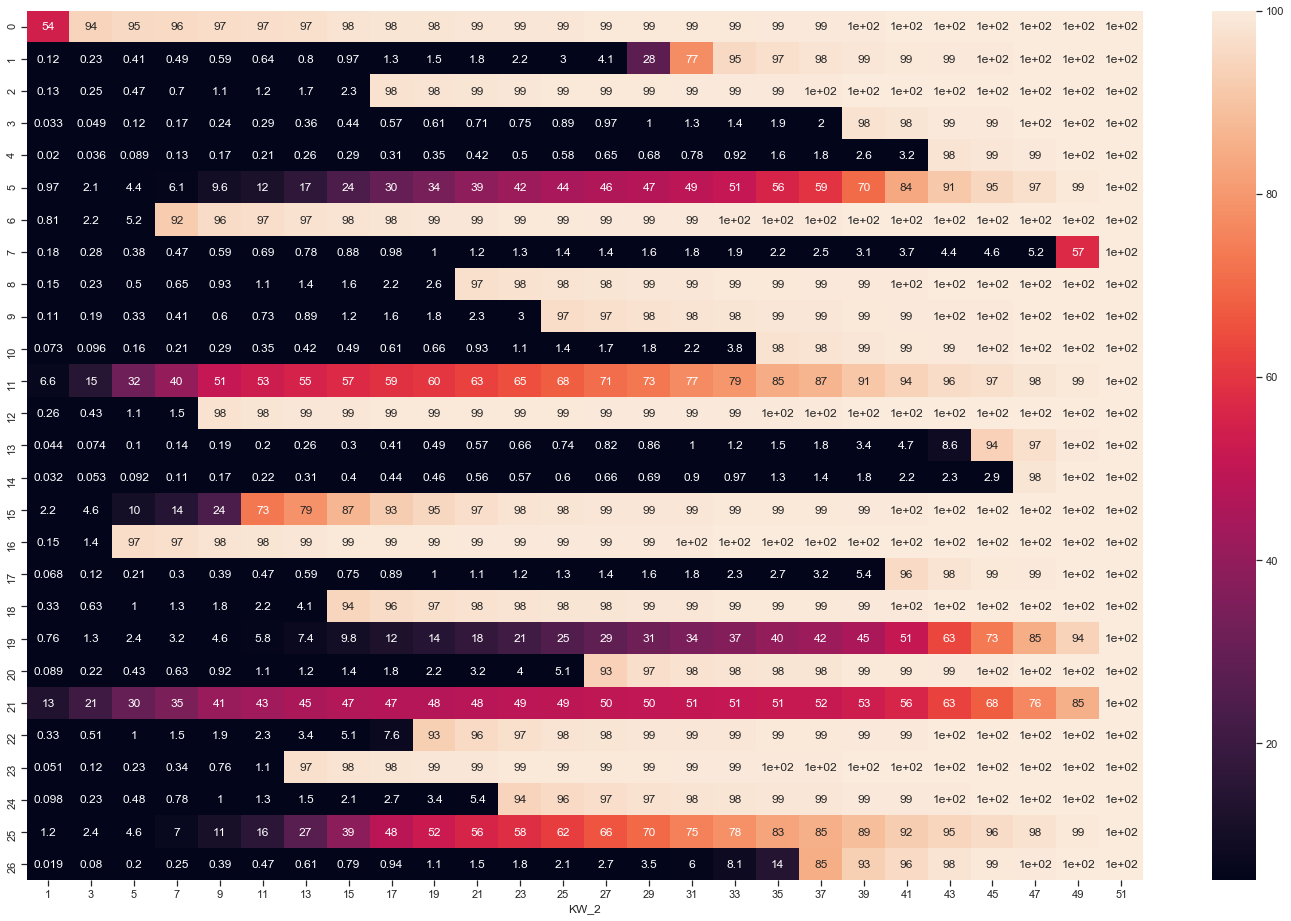

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

yr_nkmeans_clusters = pd.DataFrame(data=nkmeans.cluster_centers_, columns=X_columns)

plt.figure(figsize=(25, 16))
sns.heatmap(yr_nkmeans_clusters, annot=True, vmin=5, fmt='d')

### Cluster sizes

In [72]:
pd.Series(yr_crv_nkmeans_labels).value_counts()

5     3254
1     2684
25    2392
3     2335
10    2108
19    2003
11    1982
2     1780
16    1686
17    1641
23    1606
12    1579
4     1553
7     1544
21    1502
0     1436
8     1422
15    1343
18    1323
14    1308
9     1210
20    1047
13     972
24     931
26     918
22     813
6      731
dtype: int64

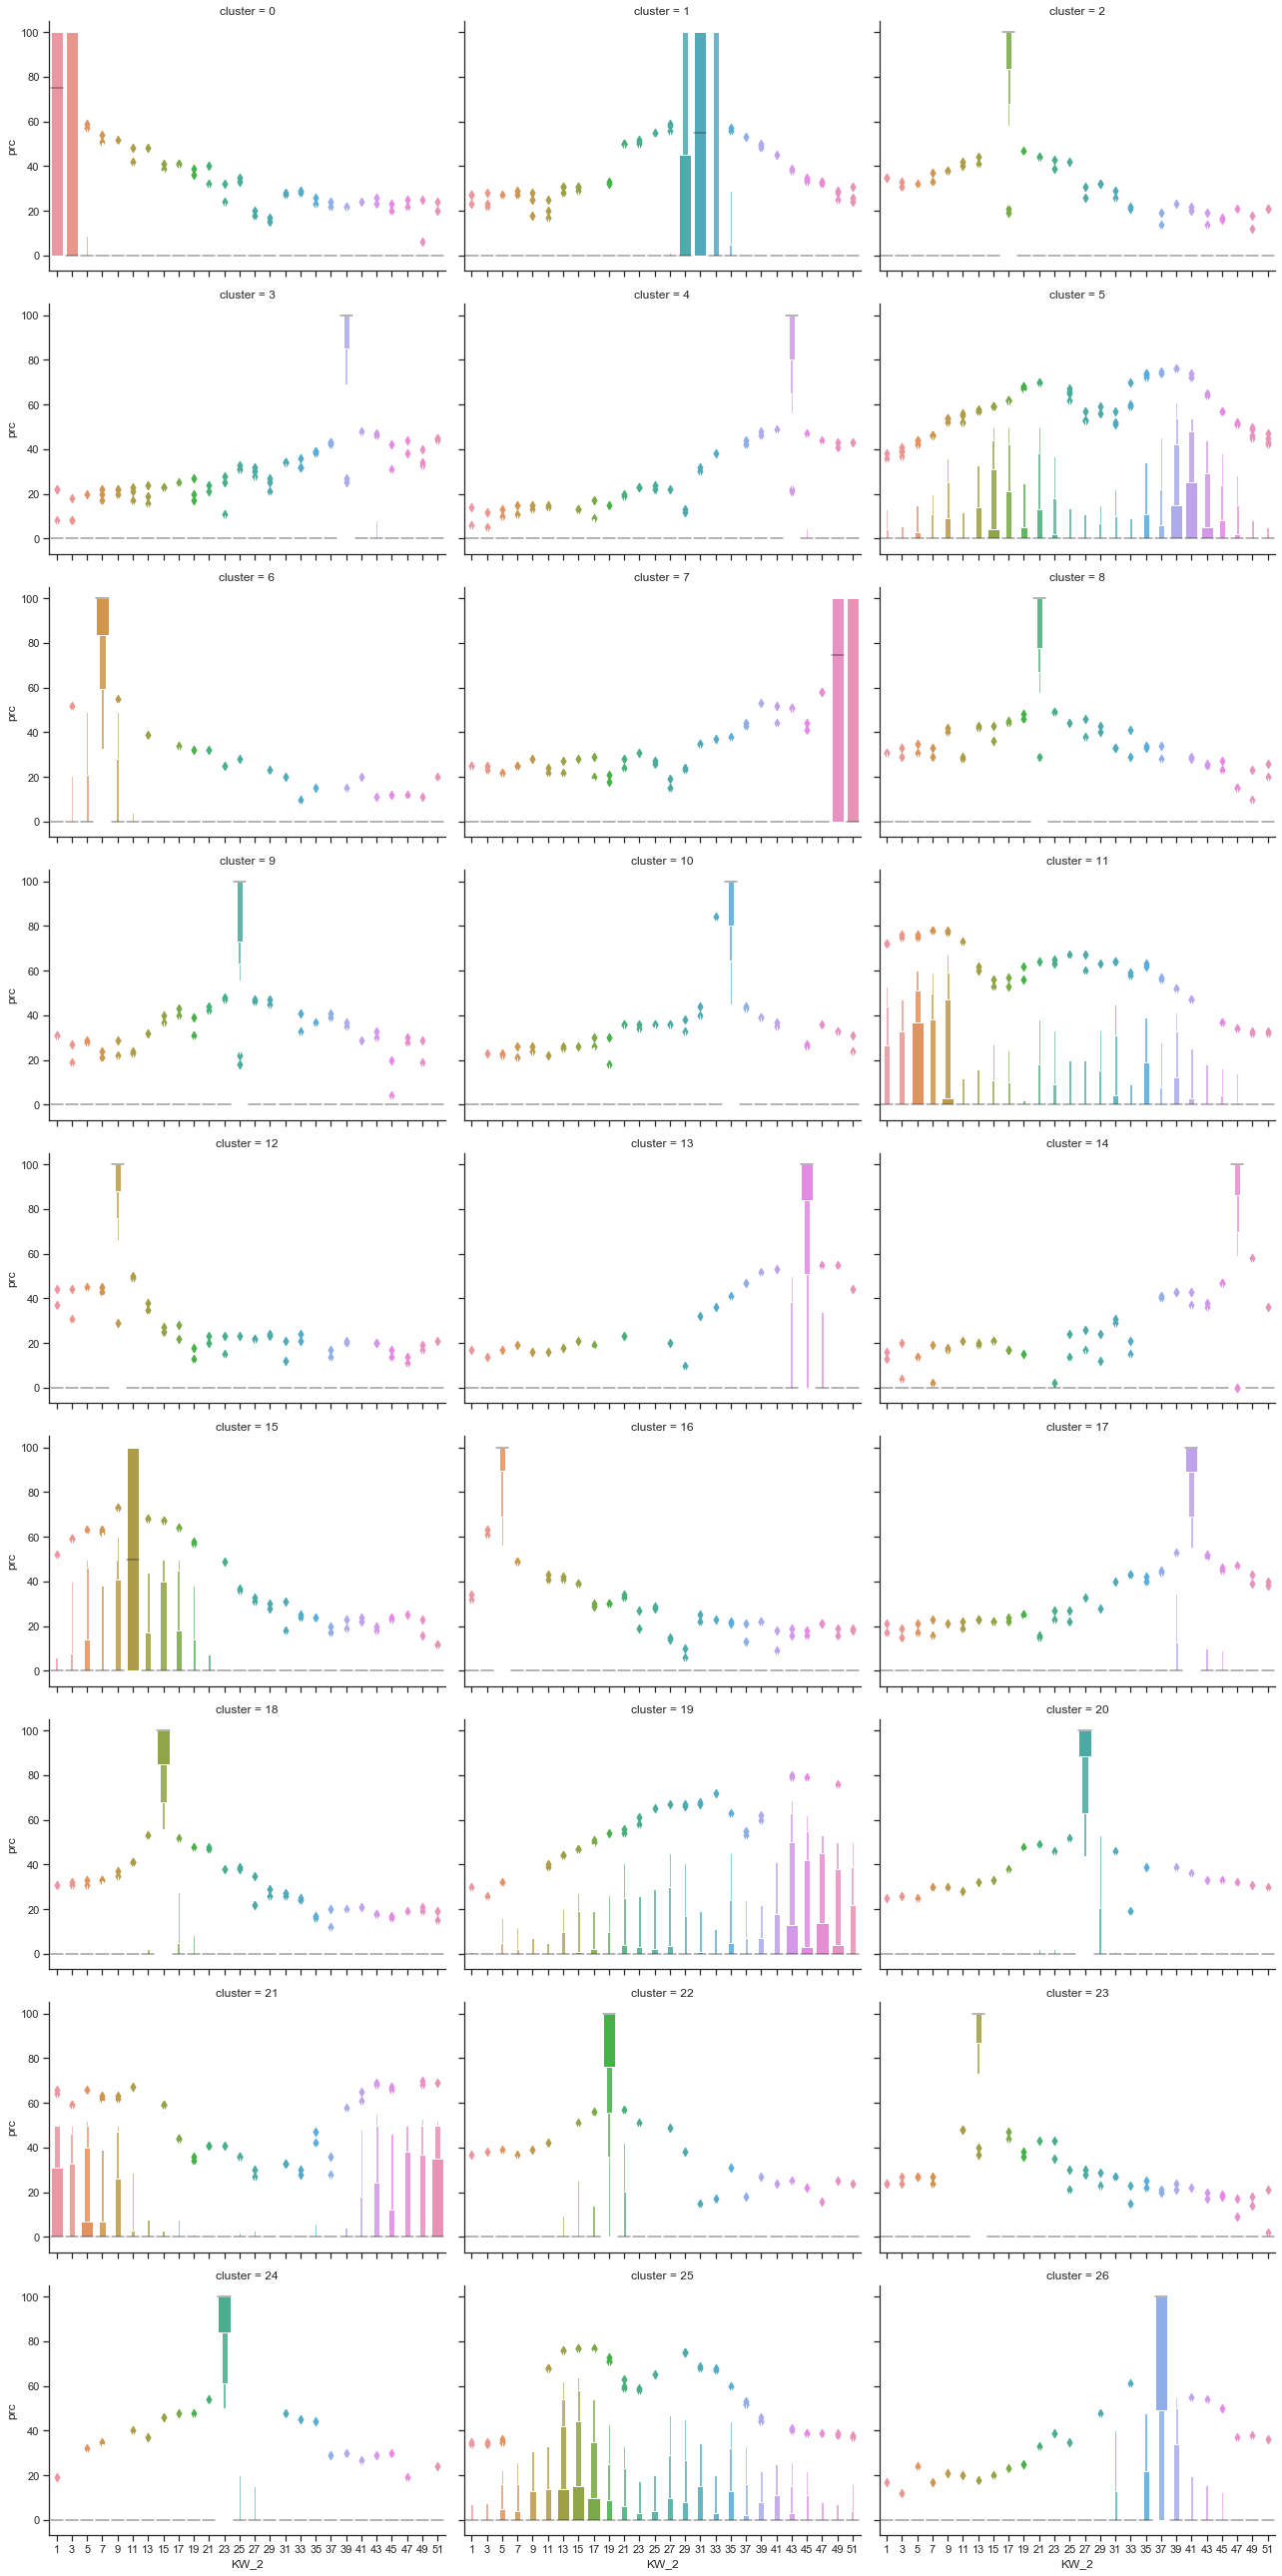

In [76]:
plot_data = pd.DataFrame.from_dict({'prc': bd_res_prc_2w_data_stack}).reset_index().merge(
    pd.Series(data=yr_crv_nkmeans_labels, index=bd_res_crv_2w_data.index, name="cluster"),
    on=["Endkunde_NR", 'Jahr'],
)

sns.catplot(
    data=plot_data,
    x="KW_2",
    y="prc",
    aspect=1.5,
    kind="boxen",
    col="cluster",
    col_wrap=3,
    height=4,
)

### Clusters matched to customers

In [74]:
ek_cls = pd.crosstab(
    index=bd_res_crv_2w_data.reset_index()["Endkunde_NR"],
    columns=pd.Series(yr_crv_nkmeans_labels, name="cluster"),
)

ek_cls_yr_cnt_ = ek_cls.copy()


def cls_list(s):
    return list(s.loc[s > 0].index.values)


def main_cls_list(s):
    return list(s.loc[s == np.max(s)].index.values)


ek_cls = ek_cls.assign(
    n_yr=ek_cls_yr_cnt_.sum(axis="columns"),
    n_cls=ek_cls_yr_cnt_.where(ek_cls > 0).count(axis="columns"),
    cls=ek_cls_yr_cnt_.apply(cls_list, axis="columns"),
    main_cls=ek_cls_yr_cnt_.apply(main_cls_list, axis="columns"),
)
ek_cls["n_main_cls"] = ek_cls["main_cls"].apply(len)

ek_cls

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,n_yr,n_cls,cls,main_cls,n_main_cls
Endkunde_NR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100034,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,3,0,0,0,0,0,10,4,"[5, 11, 19, 21]","[5, 21]",2
100039,0,1,0,0,0,2,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,3,0,10,6,"[1, 5, 11, 13, 15, 25]",[25],1
100064,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,1,0,9,3,"[12, 23, 25]",[23],1
100066,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,2,"[14, 26]","[14, 26]",2
100083,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,3,"[6, 9, 21]","[6, 9, 21]",3
100095,0,2,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,10,4,"[1, 11, 20, 25]",[11],1
100097,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,5,5,"[1, 4, 7, 14, 17]","[1, 4, 7, 14, 17]",5
100098,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,1,[3],[3],1
100104,0,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2,"[1, 5]",[1],1


### Customers that can be related to 1 or 2 clusters

In [79]:
max_main_cls = 2

yr_clust_scoring = ek_cls.query('n_main_cls < n_cls and n_main_cls <= @max_main_cls')[['main_cls']]

# Compare scoring between customer layer and year layer

In [92]:
len(np.unique(ek_clust_scoring.index.values))

4303

In [93]:
len(np.unique(yr_clust_scoring.index.values))

4335

In [94]:
pd.DataFrame({"ek": np.unique(ek_clust_scoring.index.values)}).merge(
    pd.DataFrame({"ek": np.unique(yr_clust_scoring.index.values)}),
    how="outer",
    on="ek",
    indicator=True,
)["_merge"].value_counts()

both          3947
right_only     388
left_only      356
Name: _merge, dtype: int64